# Traveling Salesman Problem

## ***Étape 1:*** Lecture du fichier .txt et initialisation de notre métrique

In [29]:
def import_fichier(path):
    """
    :param path: chemin du fichier txt à lire
    :return num_villes : nombre de villes
            villes : vecteur de coordonnées des villes
            distances : matrice des distances entre deux villes
    """
    try:
        with open(path, "r") as fichier:
            lignes = fichier.readlines()

    except FileNotFoundError:
        print(f"Le fichier {path} n'a pas été trouvé.")
    except Exception as e:
        print(f"Une erreur s'est produite : {str(e)}")

    # Création de la liste des coordonnées (x, y) des villes
    villes = []
    for i in range(1, len(lignes)):
        elements = lignes[i].split()
        if len(elements) >= 2:
            x, y = int(elements[0]), int(elements[1])
            villes.append([x, y])
    return villes

In [30]:
import math

def calcul_distance(ville1, ville2):
    """
    :param ville1:
    :param ville2:
    :return: distance euclidienne entre deux villes
    """
    x1, y1 = ville1
    x2, y2 = ville2
    return math.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)

In [31]:
def distance_totale(coords):
    """
    Calcule la distance totale en parcourant la liste de coordonnées.
    """
    total_distance = 0
    for i in range(len(coords) - 1):
        total_distance += calcul_distance(coords[i], coords[i + 1])
    # Ajoute la distance entre le dernier point et le premier pour fermer la boucle.
    total_distance += calcul_distance(coords[-1], coords[0])
    return total_distance

## ***Étape 2:*** Réalisation de notre clustering

* Dans notre travail, nous réalisions une approche clustering. En effet nous avons implémenté plusieurs approches qui fonctionnaient plutôt bien pour un nombre de villes raisonnables. Cependant lorsque le nombre de villes dépassait un certain seuil, le temps de calcul explosait ce qui nous empêchait de sortir des résultats cohérents en moins d'une minute.
* Ainsi, notre démarche a été d'obtenir des groupes de villes assez proches avec du clusturing. Ensuite, nous cherchons localement à optimiser pour chaque cluster un chemin. Puis de relier les chemins afin d'obtenir un chemin global.

In [32]:
from sklearn.cluster import KMeans

def clusturing(K, donne):
    """
    :param K: nombre de clusters
    : param donne : donne des villes à clusturer
    :return:
    centroids : centre des clusters
    labels : appartenance aux groupes
    groupe : liste de groupe des points clusturés
    """

    kmeans = KMeans(n_clusters=K)
    # Effectuer le clustering sur les données
    kmeans.fit(donne)
    # Obtenir les centres de cluster
    centroids = kmeans.cluster_centers_
    # Obtenir les étiquettes de cluster pour chaque point
    labels = kmeans.labels_

    groupe = [[] for i in range(K)]
    for i in range(len(labels)):
        L = labels[i]
        groupe[L].append(donne[i])

    return centroids, labels, groupe

## ***Étape 3:*** Relier les clusters entre eux

* L'étape 2 nous donne une liste de tous les centres des clusters. Ainsi, cherchons à optimiser la distance entre les clusters. 
* Puis nous cherchons parmi les clusters qui sont liés : quels sont les points les plus proches.
* Ce choix est discutable car même si deux centres de cluster sont les plus proches, un point d'un autre cluster peut etre plus proche d'un point d'un cluster 

### Pour trouver la plus courte distance, on utilise effectue une recherche heuristique (glouton + descente de swap)

In [33]:
import numpy as np

def plusproche_voisin(donne, depart, point_restant):
    """
    :param donne: vecteurs des coordonnées des villes
    :param depart: point de recherche
    :param point_restant: indices des villes pas encore visitées
    :return: la distance entre les deux points,indice du plus proche voisin
    """

    min = 10000
    for i in range(len(donne)):
        if i != depart and i in point_restant:
            dist = calcul_distance(donne[depart], donne[i])
            if dist < min:
                min = dist
                indice = i

    return min, indice

def permutation(config, i, j):
    """
    :param config: la liste a permuter
    :param i: indice de permutation
    :param j: indice de permutation
    :return: la liste premuté
    """

    config_inter = config.copy()
    config_inter[i] = config[j]
    config_inter[j] = config[i]
    return config_inter

def glouton(donne):
    depart = int(np.random.rand() * len(donne) // 1)
    # calcul plus proche voisin
    prems = depart
    liste_entiers = list(range(1000))
    liste_entiers.remove(depart)
    compt = 0
    config = [donne[depart]]
    distance = 0
    while compt < len(donne) - 1:
        min, indice = plusproche_voisin(donne, depart, liste_entiers)
        distance += min
        compt += 1
        liste_entiers.remove(indice)
        depart = indice
        config.append(donne[indice])
    distance += calcul_distance(donne[prems], donne[depart])

    return config, distance

def swap_descente_complete(solution, distance):
    compt = 0
    while compt < len(solution):
        for i in range(len(solution)):
            # print(i)
            if i != compt:
                # permutation
                config_tempo = permutation(solution, compt, i)
                nouvelle_distance = 0
                for i in range(len(config_tempo) - 1):
                    nouvelle_distance += calcul_distance(
                        config_tempo[i], config_tempo[i + 1]
                    )
                nouvelle_distance += calcul_distance(
                    config_tempo[len(config_tempo) - 1], config_tempo[0]
                )
                # Si la solution est la bonne
                if nouvelle_distance < distance:
                    compt = 0
                    solution = config_tempo
                    distance = nouvelle_distance
                    break
        compt += 1
    return distance, solution

In [34]:
def organisation_groupes(centroids, groupe):
    """
    :param centroids: liste des centres des clusters
    :param groupe: liste des groupes de coordonné
    :return: liste des groupes ordonnés
    """
    dist_data = []
    # Ordre de reliance des clusters
    for i in range(10):
        sol, dist = glouton(centroids)
        if i == 0:
            min = dist
            sol_opti = sol
        elif i != 0:
            if dist < min:
                min = dist
                sol_opti = sol
        dist = round(dist, 2)
        dist_data.append(dist)

    end_distance, end_solution = swap_descente_complete(sol_opti, min)
    groupe_ordonne = [0] * len(groupe)
    end_sol_temp = [list(arr) for arr in end_solution]
    for i in range(len(end_sol_temp)):
        centre = centroids[i]
        for indice, sous_liste in enumerate(end_sol_temp):
            if (sous_liste == centre)[0] and (sous_liste == centre)[1]:
                index = indice
        groupe_ordonne[index] = groupe[i]

    return groupe_ordonne

## ***Étape 4:*** Recherche des points de liaisons

* On connaît les clusters qui doivent être reliés : on cherche les points les plus proches entre toutes les liaisons.

In [35]:
def Depart_arrive(grp_av, groupe_apr):
    """
    :param grp_av: groupe 1
    :param groupe_apr: groupe 2
    :return: les deux points proches de chaque groupe
    """
    distance_min = float("inf")
    point1_plus_proche = None
    point2_plus_proche = None
    for point1 in grp_av:
        for point2 in groupe_apr:
            dist = calcul_distance(point1, point2)
            if dist < distance_min:
                distance_min = dist
                point1_plus_proche = point1
                point2_plus_proche = point2
    return [point1_plus_proche, point2_plus_proche]

In [36]:
def liste_depart_arrive(groupe):
    """
    :param groupe: groupes des points ordonnée
    :return: liste des points a connecté entre groupes
    """
    liste_depart_arrive = []
    for i in range(len(groupe) - 1):
        liste_inter = Depart_arrive(groupe[i], groupe[i + 1])
        liste_depart_arrive.append(liste_inter)
    liste_depart_arrive.append(Depart_arrive(groupe[len(groupe) - 1], groupe[0]))

    return liste_depart_arrive

## ***Étape 5:*** Optimisation aux seins des clusters

* L'étape 3 nous donne les points de départ/arrivée c'est-à-dire que l'on sait on doit commencer et terminer notre chemin.
* Pour optimiser ce chemin, on utilise la aussi une méthode glouton et swap mais cette fois-ci en imposant les points d'arrivée/départ.

In [37]:
def cherche_point(liste, point):
    """
    :param liste:
    :param point:
    :return: trouve l'indice du point dans la liste
    """
    index_trouve = None
    for index, element in enumerate(liste):
        if element == point:
            index_trouve = index
            break
    return index_trouve

In [38]:
def glouton_depart_arrive(donne, depart, arrive):
    """
    :param donne: vecteurs des villes
    :param depart: point de depart du glouton
    :param arrive: point d'arrivé du glouton
    :return: la solution, la distance totale
    """
    liste_entiers = list(range(len(donne)))
    liste_entiers.remove(depart)
    liste_entiers.remove(arrive)
    compt = 0
    config = [donne[depart]]
    distance = 0
    while compt < len(donne) - 2:
        min, indice = plusproche_voisin(donne, depart, liste_entiers)
        distance += min
        compt += 1
        liste_entiers.remove(indice)
        depart = indice
        config.append(donne[indice])
    config.append(donne[arrive])
    return config, distance

def swap_premier_dernier(solution, distance):
    """
    :param solution: vecteur de donnés
    :param distance: distance total de la solution
    :return: solution & distance total de la solution
    """
    compt = 1
    swap_reussi = False
    while compt < len(solution) - 1:
        for i in range(1, len(solution) - 1):
            if i != compt:
                # on enleve la distance des anciens
                dist1_av = calcul_distance(solution[compt], solution[compt + 1])
                dist3_av = calcul_distance(solution[i], solution[i + 1])
                dist2_av = calcul_distance(solution[compt], solution[compt - 1])
                dist4_av = calcul_distance(solution[i], solution[i - 1])

                somme_des_dists_1 = dist1_av + dist2_av + dist3_av + dist4_av

                # permutation
                config_tempo = permutation(solution, compt, i)

                # ajout des nouvelles
                dist1 = calcul_distance(config_tempo[compt], config_tempo[compt + 1])
                dist3 = calcul_distance(config_tempo[i], config_tempo[i + 1])
                dist2 = calcul_distance(config_tempo[compt], config_tempo[compt - 1])
                dist4 = calcul_distance(config_tempo[i], config_tempo[i - 1])

                somme_des_dists_2 = dist1 + dist2 + dist3 + dist4

                nouvelle_distance = distance - somme_des_dists_1 + somme_des_dists_2

                # Si la solution est la bonne
                if nouvelle_distance < distance:
                    solution = config_tempo
                    distance = nouvelle_distance
                    swap_reussi = True
                    compt = 1

        compt += 1
        if compt == (len(solution) - 1) and not swap_reussi:
            ran = np.random.rand(2) * (len(solution) - 2) // 1 + 1
            x = int(ran[0])
            y = int(ran[1])
            dist1_av = calcul_distance(solution[x], solution[x + 1])
            dist3_av = calcul_distance(solution[y], solution[y + 1])
            dist2_av = calcul_distance(solution[x], solution[x - 1])
            dist4_av = calcul_distance(solution[y], solution[y - 1])
            somme_des_dists_1 = dist1_av + dist2_av + dist3_av + dist4_av

            solution = permutation(solution, x, y)

            # ajout des nouvelles
            dist1 = calcul_distance(config_tempo[x], config_tempo[x + 1])
            dist3 = calcul_distance(config_tempo[y], config_tempo[y + 1])
            dist2 = calcul_distance(config_tempo[x], config_tempo[x - 1])
            dist4 = calcul_distance(config_tempo[y], config_tempo[y - 1])

            somme_des_dists_2 = dist1 + dist2 + dist3 + dist4

            distance = distance - somme_des_dists_1 + somme_des_dists_2
            swap_reussi = True
            compt = 1

    return distance, solution

In [39]:
def optimisation_des_groupes(groupe_ordonne, liste_depart_arriv):
    """
    :param groupe_ordonne: groupes ordonnés
    :param liste_depart_arriv: points a relier entre groupes
    :return: liste ordonnées des points a parcourir
    """
    Sol_gp = []
    liste_sol = []
    dist_total = 0
    for i in range(len(groupe_ordonne)):
        depart = cherche_point(groupe_ordonne[i], liste_depart_arriv[i - 1][1])
        arrive = cherche_point(groupe_ordonne[i], liste_depart_arriv[i][0])
        sol_gp1, dist_gp1 = glouton_depart_arrive(groupe_ordonne[i], depart, arrive)
        end_distance_gp1, end_solution_gp1 = swap_premier_dernier(sol_gp1, dist_gp1)
        liste_sol.append(end_solution_gp1)
        dist_total += end_distance_gp1
        Sol_gp = Sol_gp + end_solution_gp1
    
    return Sol_gp, dist_total, liste_sol

## ***Étape 6:*** Implémentation du solver

In [44]:
def solver(path):
    best_cluster_score = float('inf')
    best_cluster = 0
    best_chemin = []
    best_groupe=0
    data = import_fichier(path)
    
    if (len(data)<500):
        pas = 1
    else:
        pas=3

    #k est le nombre de cluster : on fait varier le pas selon la taille du .txt
    for k in range(4, 65, pas):
        centroids, labels, groupe = clusturing(k, data)
        groupe_ordonne = organisation_groupes(centroids, groupe)
        liste_depart = liste_depart_arrive(groupe_ordonne)
        try:
            sol, distance, liste_sol = optimisation_des_groupes(groupe_ordonne, liste_depart)
            distance = distance_totale(sol)
            if distance < best_cluster_score:
                best_cluster_score = distance
                best_cluster = k
                best_chemin = sol
                best_groupe = groupe_ordonne
            print("resultat pour", k, "clusters : ", distance)
        except:
            continue
    return best_cluster_score, best_cluster, best_chemin, best_groupe

## ***Étape 7:*** Affichage des résulats

* Pour afficher graphiquement, on fait afficher en couleurs les clusters ensembles et on relie avec le chemin le plus optimal trouvé

In [25]:
import matplotlib.pyplot as plt

def plot_chemin(chemin, groupe):
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'purple', 'orange', 'lime']
    # On trace les points des groupes :
    for i in range(len(groupe)):
        x_i, y_i = zip(*groupe[i])
        plt.scatter(x_i, y_i, marker='o', label=f'Groupe {i}',  c=colors[i % len(colors)])
        
    # Trace les lignes reliant les points successivement
    x, y = zip(*chemin)
    for i in range(len(chemin) - 1):
        plt.plot([x[i], x[i + 1]], [y[i], y[i + 1]], linestyle='-', linewidth=2, color='blue')
    plt.plot([x[-1], x[0]], [y[-1], y[0]], linestyle='-', linewidth=2, color='blue')
    plt.xlabel('Coordonnée x')
    plt.ylabel('Coordonnée y')
    plt.show()

In [15]:
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

## ***Exemple:*** Exploitation des 5 fichiers .txt

resultat pour 5 clusters :  334.44038370953535
resultat pour 6 clusters :  326.35251150957384
resultat pour 7 clusters :  307.3601621729558
resultat pour 8 clusters :  299.22160264730854
resultat pour 10 clusters :  294.9202400246668
resultat pour 11 clusters :  299.1200027260219
resultat pour 12 clusters :  300.4100261927408
resultat pour 14 clusters :  297.662108109728
Pour Pb1.txt - Meilleur score : 294.9202400246668 avec K= 10


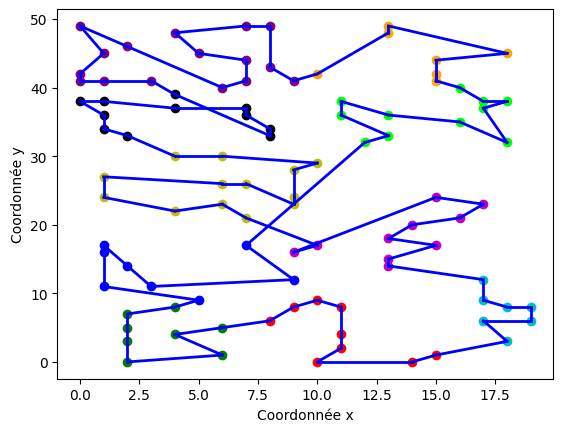

In [26]:
score1, k1, chemin1, groupe = solver('./Pb1.txt')
print('Pour Pb1.txt - Meilleur score :', score1, 'avec K=', k1)
plot_chemin(chemin1, groupe)

resultat pour 6 clusters :  432.7836910406984
resultat pour 7 clusters :  440.0300610325759
resultat pour 8 clusters :  427.9903950486463
resultat pour 9 clusters :  443.62782239331096
resultat pour 10 clusters :  442.1696221694315
resultat pour 12 clusters :  437.8466914243479
resultat pour 13 clusters :  440.44943660086517
resultat pour 14 clusters :  421.0999171069297
resultat pour 15 clusters :  429.40299384942324
resultat pour 16 clusters :  441.43783968818946
resultat pour 17 clusters :  431.21301063655324
resultat pour 19 clusters :  427.7228113529071
resultat pour 24 clusters :  427.25060825259857
Pour Pb2.txt - Meilleur score : 421.0999171069297 avec K= 14


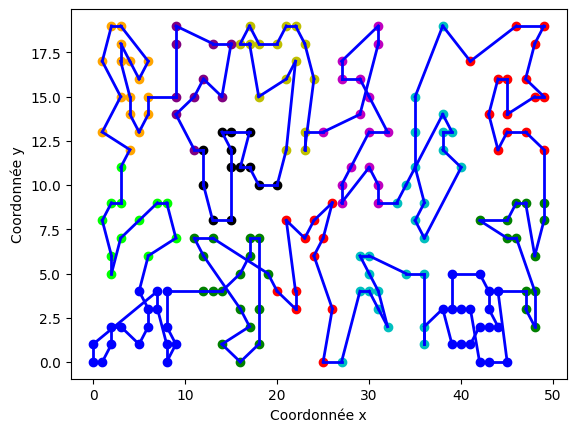

In [27]:
score2, k2, chemin2, groupe = solver('./Pb2.txt')
print('Pour Pb2.txt - Meilleur score :', score2, 'avec K=', k2)
plot_chemin(chemin2, groupe)

resultat pour 4 clusters :  1927.1970751138783
resultat pour 5 clusters :  1940.5679269384905
resultat pour 6 clusters :  1918.8029671597167
resultat pour 7 clusters :  2012.2815347573785
resultat pour 8 clusters :  1938.2247138849216
resultat pour 9 clusters :  1922.8373755808555
resultat pour 10 clusters :  1954.931084592087
resultat pour 11 clusters :  1994.3688199031694
resultat pour 12 clusters :  1899.8230066091735
resultat pour 13 clusters :  1986.515525035044
resultat pour 14 clusters :  2002.3981372111796
resultat pour 15 clusters :  1965.6722920140899
resultat pour 16 clusters :  1960.1664788512098
resultat pour 17 clusters :  1960.8423488557298
resultat pour 19 clusters :  1836.193820414026
resultat pour 20 clusters :  1919.2347820477896
resultat pour 22 clusters :  1953.9996073161358
resultat pour 24 clusters :  1971.6612140384382
resultat pour 25 clusters :  1897.8710056160623
resultat pour 27 clusters :  1848.0928678140756
resultat pour 32 clusters :  1873.069662724053
re

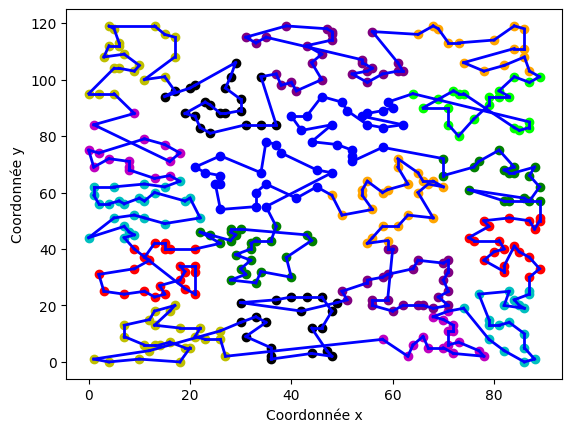

In [28]:
score3, k3, chemin3, groupe = solver('./Pb3.txt')
print('Pour Pb3.txt - Meilleur score :', score3, 'avec K=', k3)
plot_chemin(chemin3, groupe)

resultat pour 4 clusters :  6958.147369751814
resultat pour 7 clusters :  6778.888146912571
resultat pour 10 clusters :  6946.112614461457
resultat pour 13 clusters :  6903.439663443956
resultat pour 16 clusters :  6931.873340188528
resultat pour 19 clusters :  6793.443359164785
resultat pour 22 clusters :  7088.865967154899
resultat pour 25 clusters :  6775.28517627089
resultat pour 31 clusters :  6896.429730342094
resultat pour 34 clusters :  6872.916711574526
Pour Pb4.txt - Meilleur score : 6775.28517627089 avec K= 25


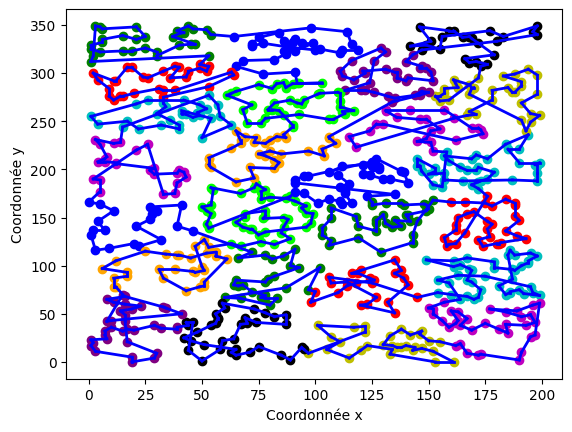

In [45]:
score4, k4, chemin4, groupe = solver('./Pb4.txt')
print('Pour Pb4.txt - Meilleur score :', score4, 'avec K=', k4)
plot_chemin(chemin4, groupe)

resultat pour 4 clusters :  11166.561731542242
resultat pour 5 clusters :  10463.866074153651
resultat pour 6 clusters :  10763.957429201164
resultat pour 7 clusters :  11018.267003395295
resultat pour 8 clusters :  10735.284065580357
resultat pour 9 clusters :  10580.380444566781
resultat pour 10 clusters :  10598.407311083329
resultat pour 11 clusters :  10584.019999870457
resultat pour 12 clusters :  10443.777915408478
resultat pour 14 clusters :  10874.875299581428
resultat pour 15 clusters :  10979.745614628297
resultat pour 18 clusters :  10800.673828282741
resultat pour 19 clusters :  10838.254827105768
resultat pour 20 clusters :  10690.474947503282
resultat pour 21 clusters :  10821.853103978636
resultat pour 22 clusters :  10533.45209258803
resultat pour 23 clusters :  10499.51099030884
resultat pour 24 clusters :  10893.087033680687
resultat pour 25 clusters :  10603.727169492851
resultat pour 26 clusters :  10614.535189756769
resultat pour 28 clusters :  10821.180673987426


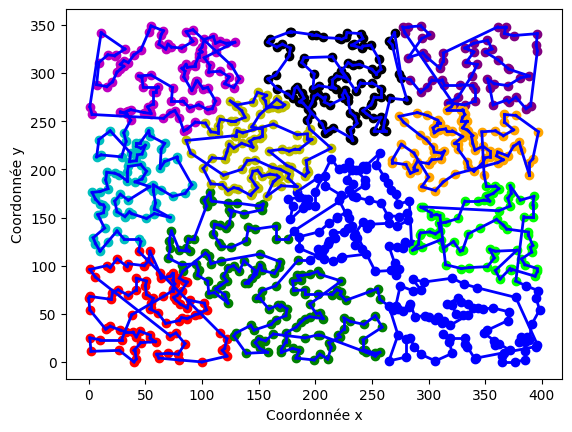

In [43]:
score5, k5, chemin5, groupe = solver('./Pb5.txt')
print('Pour Pb5.txt - Meilleur score :', score5, 'avec K=', k5)
plot_chemin(chemin5, groupe)